In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/flickr8k/captions.txt", delimiter="\t")  # Change delimiter as needed (e.g., "," for CSV)
print(df)


                  image_name|caption_number|caption_text
0      1000268201_693b08cb0e.jpg|0|A child in a pink ...
1      1000268201_693b08cb0e.jpg|1|A girl going into ...
2      1000268201_693b08cb0e.jpg|2|A little girl clim...
3      1000268201_693b08cb0e.jpg|3|A little girl clim...
4      1000268201_693b08cb0e.jpg|4|A little girl in a...
...                                                  ...
40450  997722733_0cb5439472.jpg|0|A man in a pink shi...
40451  997722733_0cb5439472.jpg|1|A man is rock climb...
40452  997722733_0cb5439472.jpg|2|A person in a red s...
40453  997722733_0cb5439472.jpg|3|A rock climber in a...
40454  997722733_0cb5439472.jpg|5|A rock climber prac...

[40455 rows x 1 columns]


In [3]:
import torch
from torchvision import transforms
from PIL import Image
import os

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224), # for augmentation
    transforms.ToTensor(),  # Converts image to [C, H, W] tensor
    # normalize using ImageNet's mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
df = df['image_name|caption_number|caption_text'].str.split('|', expand=True)
df.columns = ['image_name', 'caption_number', 'caption_text']  # Rename columns

In [6]:
df.head()

image_name caption_number  \
0  1000268201_693b08cb0e.jpg              0   
1  1000268201_693b08cb0e.jpg              1   
2  1000268201_693b08cb0e.jpg              2   
3  1000268201_693b08cb0e.jpg              3   
4  1000268201_693b08cb0e.jpg              4   

                                        caption_text  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [7]:
train_data = []
epoch = len(df)

cnt = 0

for i in range(0, epoch, 1):
    if i % 5 == 0:
        cur_path = '/kaggle/input/flickr8k/images/'
        cur_img_path = df['image_name'][i]
    
        img_path = cur_path + cur_img_path
    
        image = Image.open(img_path) 
    
        preprocessed_image = transform(image)

    train_data.append([preprocessed_image, df['caption_text'][i]])
    
len(train_data)

40455

In [8]:
print(train_data[0][0].shape)  # Access the first element of the pair (the image tensor)
# type = 3 => it is RGB type

torch.Size([3, 224, 224])


In [9]:
caption = df['caption_text']

In [10]:
word2id = {}
word2id['<SOS>'] = 0
word2id['<EOS>'] = 1
word2id['<PAD>'] = 2
word2id['<UNK>'] = 3
i = 4 
# 0 = SOS, 1 = EOS, 2 = PAD, 3 = UNK
for cap in caption:
    for word in cap.split():
        word = word.lower()
        if word not in word2id:
            word2id[word] = i
            i += 1

In [11]:
print(len(word2id))

8948


In [12]:
id2word = {v: k for k, v in word2id.items()}

In [13]:
encode_caption = []
image_data = []
def encode(sentence, max_length = 50):
    output = [] # array for storing encoding caption
    output.append(word2id['<SOS>'])
    for word in sentence.split():
        output.append(word2id[word.lower()])
    output.append(word2id['<EOS>'])
    for i in range(len(output), max_length):
        output.append(word2id['<PAD>'])
    return output
for img, caption in train_data:
    image_data.append(img)
    encode_caption.append(encode(caption))

In [14]:
# encode_caption[:5]

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

class ImageCaptionDataset(Dataset):
    def __init__(self, captions, image):
        self.captions = captions
        self.image = image
    def __len__(self):
        return len(self.captions)
    def __getitem__(self, idx):
        return torch.tensor(self.image[idx]), torch.tensor(self.captions[idx])

In [16]:
train_idx = int(0.65 * len(train_data))
val_idx = int(0.8 * len(train_data))
print(train_idx)
print(val_idx)

26295
32364


In [17]:
train_dataset = ImageCaptionDataset(encode_caption[:train_idx], image_data[:train_idx])
valid_dataset = ImageCaptionDataset(encode_caption[train_idx : val_idx], image_data[train_idx : val_idx])
test_dataset = ImageCaptionDataset(encode_caption[val_idx:], image_data[val_idx:])

In [18]:
print(train_dataset[0])
print(type(train_dataset), train_dataset)

(tensor([[[ 1.5639,  2.1290,  0.6221,  ...,  0.3652, -0.3541, -1.0048],
         [ 1.7523,  1.7694,  0.3823,  ...,  0.6221,  0.0569, -0.2684],
         [ 1.7865,  1.2385,  0.2282,  ...,  0.7419,  0.3309, -0.4739],
         ...,
         [-0.5596, -0.0801,  0.0741,  ...,  2.1975,  2.2147,  2.1975],
         [ 0.0569,  0.1768,  0.1768,  ...,  2.2147,  2.2147,  2.1804],
         [ 0.1426,  0.1768,  0.1254,  ...,  2.2147,  2.2147,  2.1975]],

        [[ 1.2381,  2.2010,  0.9580,  ...,  1.0280,  0.1702, -0.6176],
         [ 1.5182,  1.9209,  0.7129,  ...,  1.5357,  1.1155,  0.5728],
         [ 1.5532,  1.3957,  0.6078,  ...,  1.6057,  1.2906,  0.3102],
         ...,
         [-0.6001, -0.2150, -0.0049,  ...,  2.4111,  2.3936,  2.3410],
         [-0.0749, -0.0049,  0.0126,  ...,  2.3936,  2.3936,  2.3936],
         [-0.0574,  0.0126, -0.0574,  ...,  2.3936,  2.3761,  2.3585]],

        [[ 0.6531,  1.1411,  0.3916,  ..., -0.3404, -0.6715, -1.0550],
         [ 0.8448,  1.1062,  0.3742,  ..., -

<ipython-input-15-cb2a05ce150e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.image[idx]), torch.tensor(self.captions[idx])


In [19]:
BATCH_SIZE = 32 * 4
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [20]:
from torch import nn
from torchvision import models
import torch.nn.init as init

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True) # get resnet50 model for extracting image
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.batch = nn.BatchNorm1d(embed_size, momentum=0.01)

        init.normal_(self.embed.weight, mean=0.0, std = 0.02)
        init.constant_(self.embed.bias, 0)
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.batch(self.embed(features))
        return features
        

In [21]:
embed_size = 256
vocab_size = len(word2id)
dummy_input = torch.randn([5, 3, 224, 224])
encoder = EncoderCNN(embed_size)
encoder.eval()
output = encoder(dummy_input)
output.shape

# get the 256 sequence length based on the input 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


torch.Size([5, 256])

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, feature_dim=2048):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size) # [vocab_size, embedding_dim]
        # self.fc = nn.Linear(feature_dim, embed_size) # optional
        self.lstm = nn.LSTM(embed_size, hidden_size)
        self.linear = nn.Linear(hidden_size, vocab_size) # output layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions)) # [batch_size, seq_len, embed_size]
        embeddings = embeddings.transpose(0, 1) # [seq_len, batch_size, embed_size]
        features = features.unsqueeze(0)
        embeddings = torch.cat((features, embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


decoder = DecoderRNN(embed_size, 512, vocab_size)

# Correctly create dummy_inp2 using torch.randint:
dummy_inp2 = torch.randint(0, vocab_size, (5, 50))

t_output = decoder(output, dummy_inp2)

t_output.shape

torch.Size([51, 5, 8948])

In [23]:
class Encoder_Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
    def forward(self, images, captions):
        features = self.encoder(images)
        output = self.decoder(features, captions)
        return output
    def sample(self, images, max_len=50):
        features = self.encoder(images)
        batch_size = features.size(0)
        sampled_ids = [] # list to store word_id
        inputs = features.unsqueeze(0)
        state = None
        for t in range(max_len):
            hidden, state = self.decoder.lstm(inputs, state)
            logits = self.decoder.linear(hidden.squeeze(0)) # (batch, vocab_size)
            predicted = logits.argmax(dim=1)
            sampled_ids.append(predicted)
            inputs = self.decoder.embed(predicted)
            inputs = inputs.unsqueeze(0)
        sampled_ids = torch.stack(sampled_ids, dim = 1)
        return sampled_ids


In [24]:
device = 'cuda'
model = Encoder_Decoder(embed_size, 512, vocab_size).to(device)

In [25]:
from torch import optim
import torch.nn as nn
import torch

def evaluate_loss(model, val_dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, captions in val_dataloader:
            images = images.to(device)
            captions = captions.to(device)

            # Create inputs and targets for teacher forcing
            input_captions = captions[:, :-1]
            target_captions = captions[:, 1:] # shape: [batch_size, seq_len - 1]
            
            outputs = model(images, input_captions) # shape [seq_len, batch_size, vocab_size]
            outputs = outputs[1:] # shape: [seq_len - 1, batch_size, vocab_size]
            outputs = outputs.transpose(0, 1) # shape = [batch_size, seq_len - 1, vocab_size]
            # print("Outputs shape:", outputs.shape)
            # print("Target captions shape:", target_captions.shape)
            preds = outputs.reshape(-1, outputs.size(-1))          # [128*49, 8948] = [6272, 8948]
            # print("Preds shape: ", preds.shape)
            targets = target_captions.reshape(-1)# [128*49] = [6272]
            # print("Target shape: ", targets.shape)
            loss = criterion(preds, targets)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(val_dataloader)
    model.train()  # back to training mode
    return avg_loss


In [26]:
def train(model, train_dataloader, epochs, lr, device):
    criterion = nn.CrossEntropyLoss(ignore_index = word2id['<PAD>'])
    params = list(model.decoder.parameters()) + list(model.encoder.embed.parameters()) + list(model.encoder.batch.parameters())
    optimizer = optim.Adam(params, lr = lr)
    model.train()
    for epoch in range(epochs):
        total_loss =0.0
        for batch_idx, (images, captions) in enumerate(train_dataloader):
            images = images.to(device)
            captions = captions.to(device) # shape = [batch_size, seq_len ]
            input_captions = captions[:, : - 1] # shape [batch_size, seq_len  - 1]
            # print("Input shape: ", input_captions.shape)
            target_captions = captions[:, 1 :] # shape : [batch_size, seq_len - 1]
            # print("Target captions: ", target_captions.shape)
            optimizer.zero_grad()
            outputs = model(images, input_captions) # shape = [seq_len, batch_size, vocab_size]
            # print("Output shape ", outputs.shape)
            outputs = outputs[1:] # shape = [seq_len - 1, batch_size, vocab_size]
            # print("Output shape 2: ", outputs.shape)
            outputs = outputs.transpose(0, 1) # shape: [batch_size, seq_len - 1, vocab_size]
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), 
                            target_captions.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
        val_loss = evaluate_loss(model, val_dataloader, nn.CrossEntropyLoss(ignore_index=word2id['<PAD>']), device)
        print(f"Validation Loss: {val_loss:.4f}")
        
        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}")

In [27]:
train(model, train_dataloader, 10, 1e-3, device)

<ipython-input-15-cb2a05ce150e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.image[idx]), torch.tensor(self.captions[idx])


Epoch [1/10], Step [10/206], Loss: 5.7988
Epoch [1/10], Step [20/206], Loss: 5.0898
Epoch [1/10], Step [30/206], Loss: 4.7910
Epoch [1/10], Step [40/206], Loss: 4.6481
Epoch [1/10], Step [50/206], Loss: 4.3475
Epoch [1/10], Step [60/206], Loss: 4.3279
Epoch [1/10], Step [70/206], Loss: 4.1461
Epoch [1/10], Step [80/206], Loss: 4.1787
Epoch [1/10], Step [90/206], Loss: 4.1571
Epoch [1/10], Step [100/206], Loss: 3.9588
Epoch [1/10], Step [110/206], Loss: 3.9704
Epoch [1/10], Step [120/206], Loss: 3.9395
Epoch [1/10], Step [130/206], Loss: 3.6720
Epoch [1/10], Step [140/206], Loss: 3.8216
Epoch [1/10], Step [150/206], Loss: 3.7573
Epoch [1/10], Step [160/206], Loss: 3.7354
Epoch [1/10], Step [170/206], Loss: 3.7065
Epoch [1/10], Step [180/206], Loss: 3.6447
Epoch [1/10], Step [190/206], Loss: 3.6023
Epoch [1/10], Step [200/206], Loss: 3.5421
Validation Loss: 3.6342
Epoch [1/10] Average Loss: 4.2538
Epoch [2/10], Step [10/206], Loss: 3.4420
Epoch [2/10], Step [20/206], Loss: 3.4238
Epoch [

In [28]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms



torch.Size([1, 3, 224, 224])


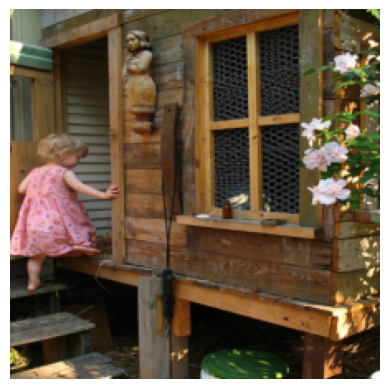

a girl in a white shirt is standing in front of a brick wall .
torch.Size([1, 3, 224, 224])


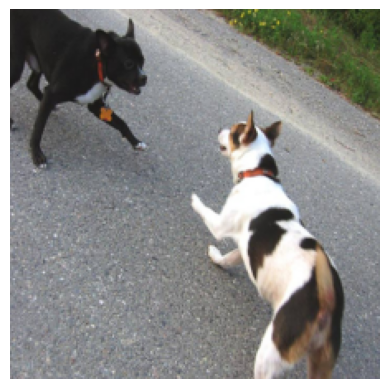

two dogs play together .
torch.Size([1, 3, 224, 224])


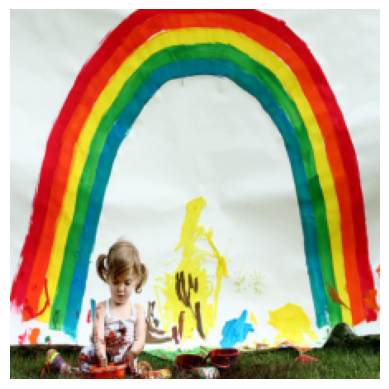

yellow robot and white dog is running through the grass .
torch.Size([1, 3, 224, 224])


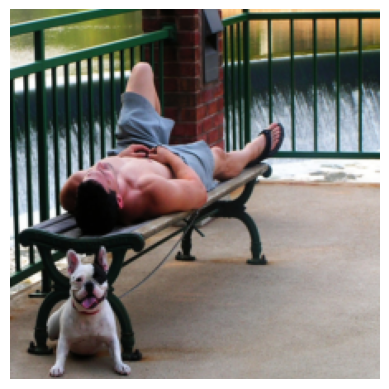

cat inspecting fire and dogs .
torch.Size([1, 3, 224, 224])


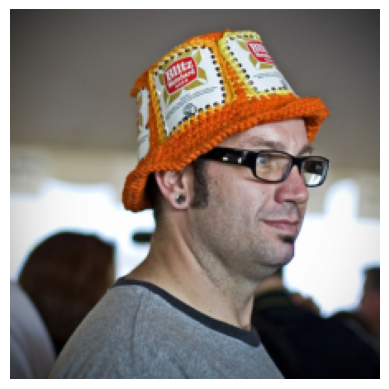

firefighter asking vegas orchestra illustrated opposition recoiling proof confronted second-story manner scrimmage skin egytian-like rice aross look-alike jersy glee link narby calculate tumbleweed layered tub cds twists beaks soldier lets shorthair alcove bangs ledges ledges texas paisley cds twists beaks soldier lets wristband rice aross call egytian-like rice judgement egytian-like
torch.Size([1, 3, 224, 224])


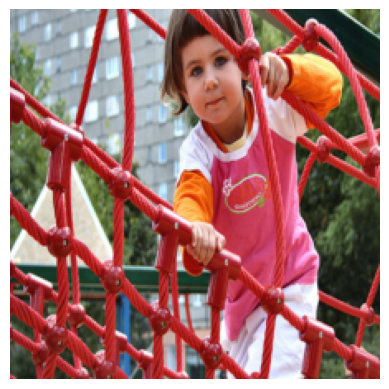

two girls swing on a rope swing .
torch.Size([1, 3, 224, 224])


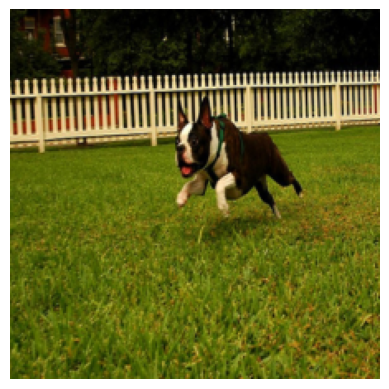

and black dog is running through a field .
torch.Size([1, 3, 224, 224])


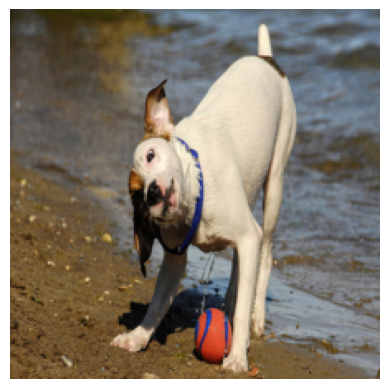

white dog with a stick in its mouth .
torch.Size([1, 3, 224, 224])


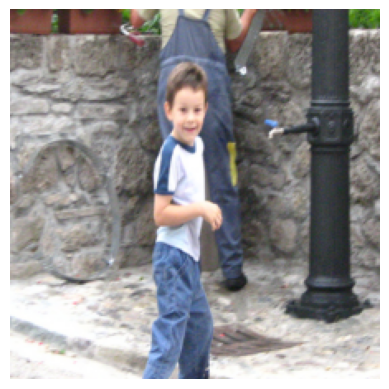

boy standing on a rock wall .
torch.Size([1, 3, 224, 224])


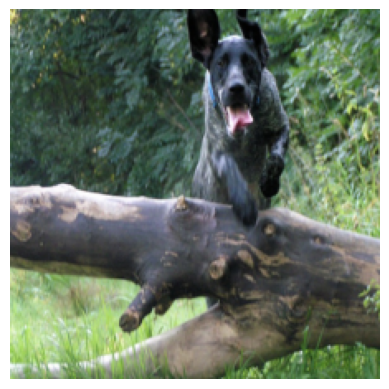

a black dog jumps over a tree .
torch.Size([1, 3, 224, 224])


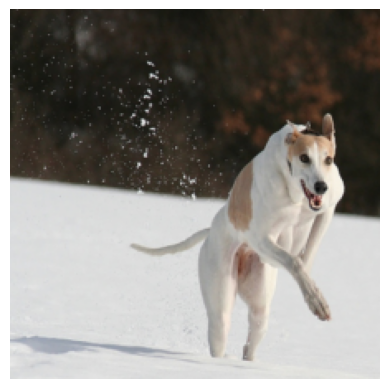

white and brown dog is running through the snow .
torch.Size([1, 3, 224, 224])


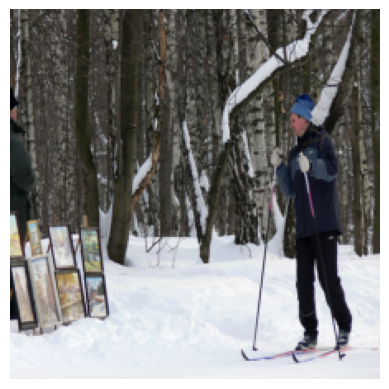

skier skier sitts watch it shaking file terrain
torch.Size([1, 3, 224, 224])


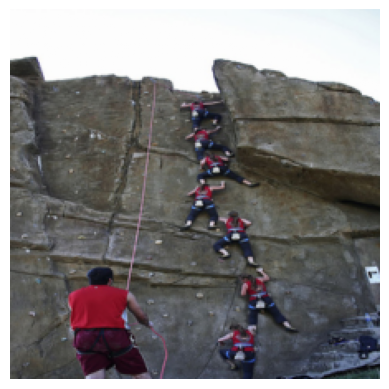

climber collage controls rice aross maintained enviorment eyeshadow skin grip alcove bangs ledges ledges texas paisley cds twists beaks soldier lets wristband rice aross call egytian-like rice judgement egytian-like rice aross enviorment eyeshadow skin grip alcove bangs ledges ledges texas paisley cds twists beaks soldier lets wristband rice aross call
torch.Size([1, 3, 224, 224])


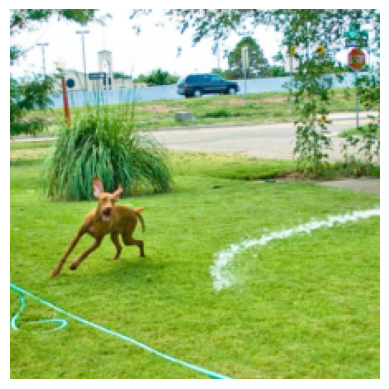

dog running through the grass .
torch.Size([1, 3, 224, 224])


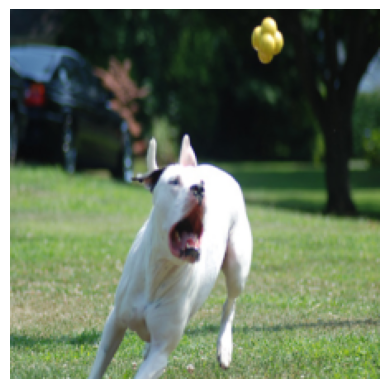

white dog catching a frisbee .
torch.Size([1, 3, 224, 224])


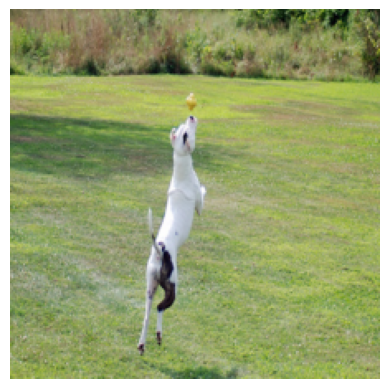

is running through a field .
torch.Size([1, 3, 224, 224])


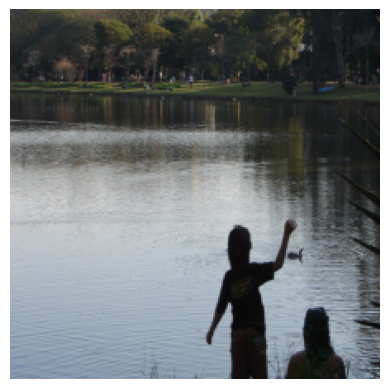

black dog jumping into the water .
torch.Size([1, 3, 224, 224])


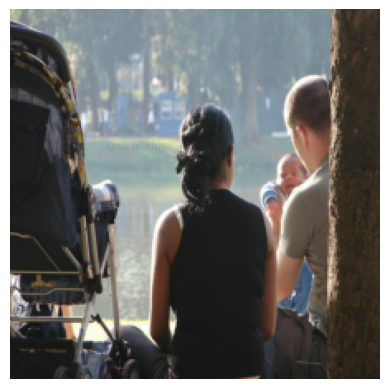

couple sitting sitting atop a man sitting on a rock .
torch.Size([1, 3, 224, 224])


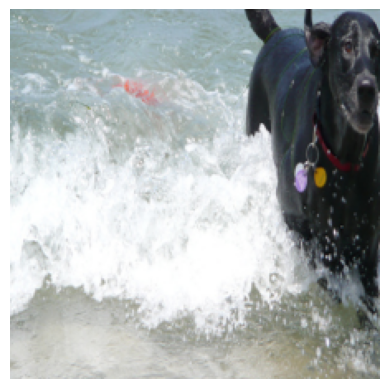

a black dog is running through the water .
torch.Size([1, 3, 224, 224])


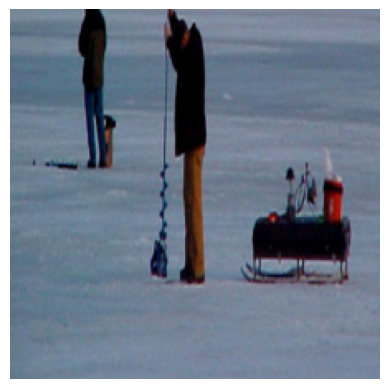

man fishing into the water .


In [29]:

import torch
import matplotlib.pyplot as plt

model.eval()
for i in range(0, 100, 5):
    img = image_data[i]
    img = img.to(device)
    img = img.unsqueeze(0)
    print(img.shape)
    encode_output = model.sample(img)
    # Ensure mean and std are on the same device
    img = img.squeeze(0)
    device = img.device  
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    # Denormalize the image (if normalized)
    img = img * std + mean  # Undo normalization
    
    # Move to CPU before converting to NumPy
    img_numpy = img.cpu().permute(1, 2, 0).clamp(0, 1).numpy()
    # Display the image
    plt.imshow(img_numpy)
    plt.axis('off')  # Hide axis
    plt.show()
    encode_output = encode_output.squeeze(0).tolist()
    true_output = []
    for char in encode_output:
        if char == 0: 
            continue
        elif char == 1:
            break
        true_character = id2word[char]
        true_output.append(true_character)
    generated_captions = ' '.join(true_output)
    print(generated_captions)